In [ ]:
from PIL import Image
import requests, sqlite3,tqdm
from io import BytesIO
import pandas as pd

%load_ext autoreload
%autoreload 2
import dashDBHelpers as hlprs

dbName = "sqlite/confMatrixDB.db"

hlprs.createMatrixTables(dbName)
hlprs.createItemTable(dbName)
hlprs.insertItemData(dbName)

In [2]:
import json
with open("./imageSetForCm.json", "r") as fp:
    imageSetList = json.load(fp)

In [ ]:
from transformers import pipeline
classifer = pipeline("image-classification",model="models/stainID_model/")

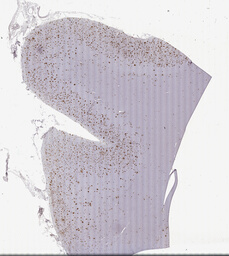

In [3]:
from PIL import Image
import requests
from io import BytesIO
dsaBaseUrl = "https://styx.neurology.emory.edu/girder/api/v1"

imgId = imageSetList[0]['_id']
thumbUrl = f'{dsaBaseUrl}/item/{imgId}/tiles/thumbnail'
response = requests.get(thumbUrl)
img = Image.open(BytesIO(response.content))
img.show()

In [ ]:
dsaBaseUrl = "https://styx.neurology.emory.edu/girder/api/v1"
predictionData = []


#for i in tqdm.tqdm(imageSetList[0:5]):
for i in tqdm.tqdm(imageSetList):
    if 'npSchema' in i['meta'] and 'stainID' in i['meta']['npSchema']:
        npStain = i['meta']['npSchema']['stainID']

        
        thumbUrl = f'{dsaBaseUrl}/item/{i["_id"]}/tiles/thumbnail'
        response = requests.get(thumbUrl)

        c = classifer.predict(Image.open(BytesIO(response.content)))
#         print(npStain,i['name'],c[0]['label'])
        
        p = {'currentStain':npStain,'imageName':i['name'],'predictedStain':c[0]['label'],'predictedConf':c[0]['score'],'allPredictions': c}
        predictionData.append(p)
#         print(c)


In [ ]:
with open("predictionSample.json","w") as fp:
    json.dump(predictionData,fp)

In [ ]:
from sklearn.metrics import confusion_matrix
import pylab as pl
y_test=['business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business', 'business']

# pred=array(['health', 'business', 'business', 'business', 'business',
#        'business', 'health', 'health', 'business', 'business', 'business',
#        'business', 'business', 'business', 'business', 'business',
#        'health', 'health', 'business', 'health'], 
#       dtype='|S8')

cm = confusion_matrix(y_test, pred)
pl.matshow(cm)
pl.title('Confusion matrix of the classifier')
pl.colorbar()
pl.show()

In [ ]:
y_test = [y['currentStain'] for y in predictionData]
y_pred = [y['predictedStain'] for y in predictionData]

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,y_pred)

In [ ]:
import pandas as pd


df = pd.DataFrame(cm)
# confusionMatrix = confusion_matrix(labels, outputLabels, classCount=ip.classCount)
# df = pd.DataFrame(confusionMatrix)

# names = {ind: name for ind, name in zip(df.index, ip.uniqueClasses)}

# df.rename(columns=names, index=names, inplace=True)
df.astype(int).style.background_gradient(cmap ='viridis').set_properties(**{'font-size': '20px'})


In [ ]:

# display_labels =['aBeta','Biels','HE','Tau','pTDP']

# cm = metrics.confusion_matrix(y_test,y_pred)
# cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=display_labels)
# cm_display.plot()
# plt.show()



In [7]:
with open("predictionSample.json","r") as fp:
    preds = json.load(fp)

In [9]:
import pandas as pd
df = pd.DataFrame(preds)
df

,currentStain,imageName,predictedStain,predictedConf,allPredictions
0,No Stain Identified,Ab con.svs_thumb_1024.jpg,Abeta,0.990065,"[{'score': 0.9900652766227722, 'label': 'Abeta..."
1,No Stain Identified,Ab con.svs_thumb_2048.jpg,Abeta,0.990033,"[{'score': 0.9900327920913696, 'label': 'Abeta..."
2,Biels,Biels con.svs_thumb_1024.jpg,Biels,0.987993,"[{'score': 0.9879933595657349, 'label': 'Biels..."
3,Biels,Biels con.svs_thumb_2048.jpg,Biels,0.987973,"[{'score': 0.9879727363586426, 'label': 'Biels..."
4,aBeta,E19-131_1 Ab.svs_thumb_1024.jpg,Ptdp,0.457918,"[{'score': 0.4579184949398041, 'label': 'Ptdp'..."
...,...,...,...,...,...
1220,HE,E19-97_5 HE.svs_thumb_1024.jpg,He,0.992210,"[{'score': 0.9922102689743042, 'label': 'He'},..."
1221,HE,E19-97_6 HE.svs_thumb_1024.jpg,He,0.992220,"[{'score': 0.9922198057174683, 'label': 'He'},..."
1222,HE,E19-97_7 HE.svs_thumb_1024.jpg,He,0.992166,"[{'score': 0.9921658039093018, 'label': 'He'},..."
1223,HE,E19-97_8 HE.svs_thumb_1024.jpg,He,0.991999,"[{'score': 0.9919989705085754, 'label': 'He'},..."


In [58]:

lbl = df['currentStain'].value_counts() > 100

df1 = df[df['currentStain'].map(df['currentStain'].value_counts()) > 100]
df1.currentStain.unique()


array(['Biels', 'aBeta', 'HE', 'Tau', 'pTDP', 'Syn'], dtype=object)

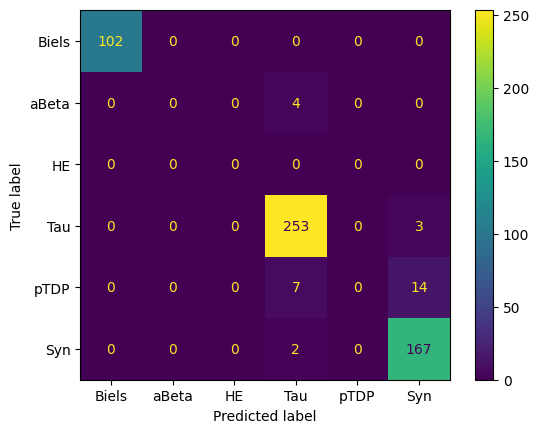

In [61]:
lblSet = ['HE','Tau','Syn','aBeta','pTDP','Biels']
from sklearn import metrics
cm = metrics.confusion_matrix( list(df1.currentStain.values), list(df1.predictedStain.values), labels=df1.currentStain.unique())

fig = metrics.ConfusionMatrixDisplay(cm,display_labels=df1.currentStain.unique())
fig.plot()

In [71]:
px.scatter(cm,x='')

In [73]:
cm
# import plotly.express as px

# px.histogram(df1,x='currentStain')

array([[102,   0,   0,   0,   0,   0],
       [  0,   0,   0,   4,   0,   0],
       [  0,   0,   0,   0,   0,   0],
       [  0,   0,   0, 253,   0,   3],
       [  0,   0,   0,   7,   0,  14],
       [  0,   0,   0,   2,   0, 167]])

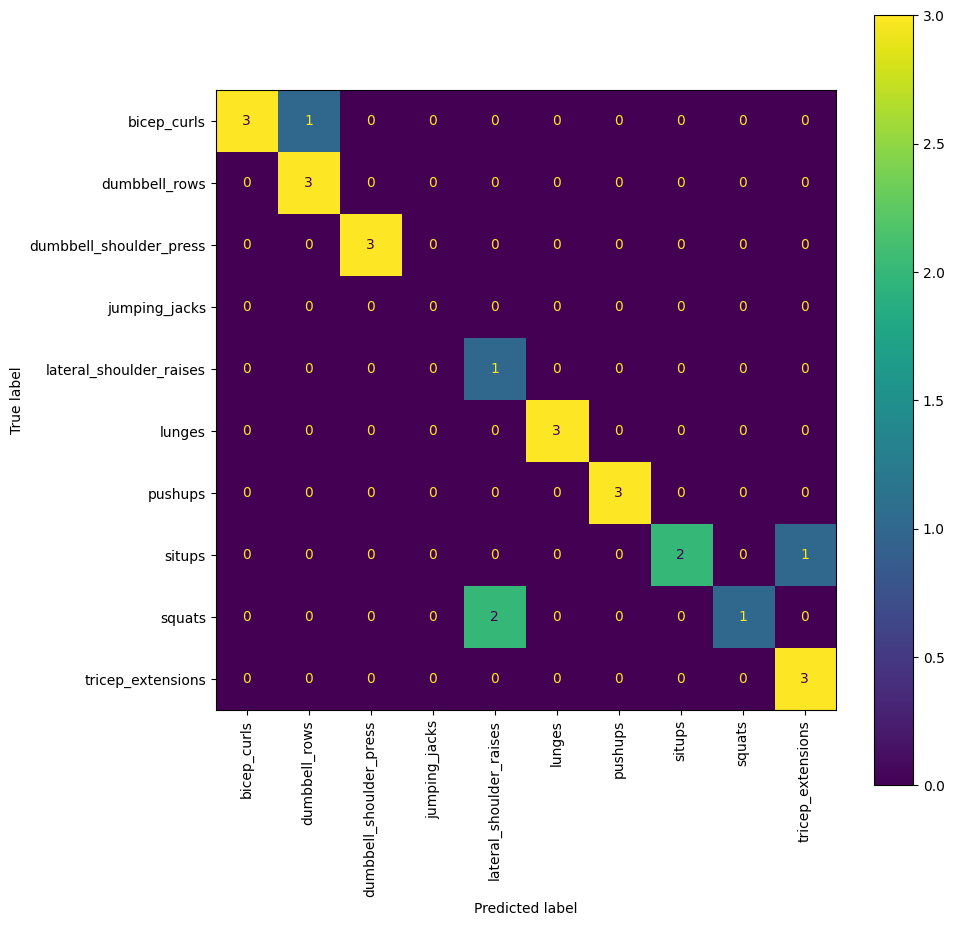

In [44]:
# import matplotlib.pyplot as plt
# import numpy as np
# import pandas as pd
# from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
# from sklearn.preprocessing import LabelEncoder

# ex_classes = {
#     "Classes": [
#         "bicep_curls",
#         "dumbbell_rows",
#         "dumbbell_shoulder_press",
#         "jumping_jacks",
#         "lateral_shoulder_raises",
#         "lunges",
#         "pushups",
#         "situps",
#         "squats",
#         "tricep_extensions",
#     ]
# }
# df_classes = pd.DataFrame(data=ex_classes)
# label_enc = LabelEncoder()
# label_enc.fit(df_classes["Classes"])

# y_test = np.asarray(
#     [8, 8, 8, 6, 6, 6, 2, 2, 2, 5, 5, 5, 1, 1, 1, 7, 7, 7, 9, 9, 9, 0, 0, 0, 0, 4]
# )
# y_pred = np.asarray(
#     [8, 4, 4, 6, 6, 6, 2, 2, 2, 5, 5, 5, 1, 1, 1, 9, 7, 7, 9, 9, 9, 0, 0, 1, 0, 4]
# )
# cm = confusion_matrix(y_test, y_pred, labels=np.arange(len(df_classes)))
# display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_enc.classes_)
# fig, ax = plt.subplots(figsize=(10, 10))
# display.plot(ax=ax, xticks_rotation="vertical")
# plt.show()

Confusion matrix, without normalization
[[13  0  0]
 [ 0 13  3]
 [ 0  0  9]]
Normalized confusion matrix
[[1.   0.   0.  ]
 [0.   0.81 0.19]
 [0.   0.   1.  ]]


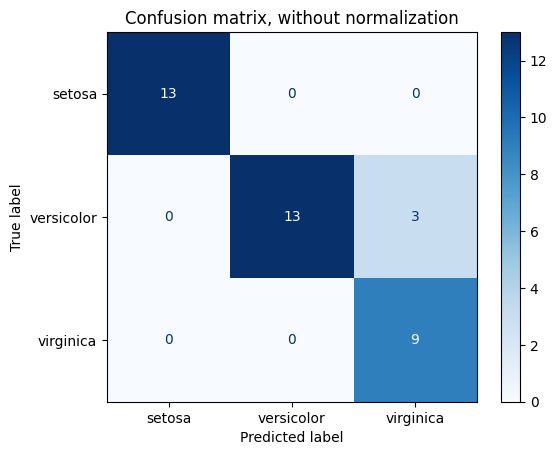

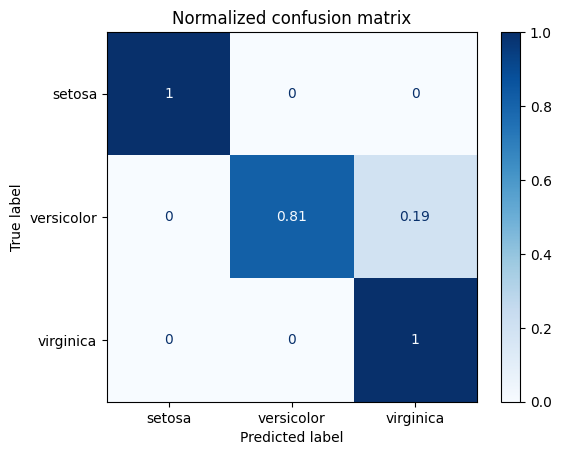

In [47]:
import numpy as num
import matplotlib.pyplot as plot

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay


iris = datasets.load_iris()
x = iris.data
y = iris.target
class_names = iris.target_names


x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0)


classifier = svm.SVC(kernel="linear", C=0.02).fit(x_train, y_train)

num.set_printoptions(precision=2)

title_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in title_options:
    display = ConfusionMatrixDisplay.from_estimator(
        classifier,
        x_test,
        y_test,
        display_labels=class_names,
        cmap=plot.cm.Blues,
        normalize=normalize,
    )
    display.ax_.set_title(title)

    print(title)
    print(display.confusion_matrix)

plot.show()

In [74]:
df = pd.read_json("predictionSample.json")

In [79]:
df = pd.read_csv("./adrcThumbMetadata.csv")
df

,Unnamed: 0,caseID,blockID,stainID,regionName,regionAbbreviation,path,name,controlSlide
0,0,E20-122,10,HE,Posterior basal ganglia,p-Bsl Gngl,/data/ADRC_Thumbs/2020/E20-122/scanned images/...,E20-122_10_HE.svs_small.jpg,NaN
1,2,E20-122,2,HE,Amygdala,Amyg,/data/ADRC_Thumbs/2020/E20-122/scanned images/...,E20-122_2_HE.svs_small.jpg,NaN
2,3,E20-122,2,aBeta,Amygdala,Amyg,/data/ADRC_Thumbs/2020/E20-122/scanned images/...,E20-122_2_AB.svs_small.jpg,NaN
3,4,E20-122,7,HE,Cingulate cortex,NaN,/data/ADRC_Thumbs/2020/E20-122/scanned images/...,E20-122_7_HE.svs_small.jpg,NaN
4,5,E20-122,14,Syn,Pons,Pons,/data/ADRC_Thumbs/2020/E20-122/scanned images/...,E20-122_14_SYN.svs_small.jpg,NaN
...,...,...,...,...,...,...,...,...,...
4307,4307,NaN,NaN,Syn,NaN,NaN,/data/ADRC_Thumbs/2022/E22-48/scanned images/E...,E22-48_SYN_CONTROL.svs_small.jpg,Yes
4308,4308,NaN,NaN,aBeta,NaN,NaN,/data/ADRC_Thumbs/2022/E22-48/scanned images/E...,E22-48_ABETA_CONTROL.svs_small.jpg,Yes
4309,4309,NaN,NaN,pTDP,NaN,NaN,/data/ADRC_Thumbs/2022/E22-48/scanned images/E...,E22-48_pTDP_CONTROL.svs_small.jpg,Yes
4310,4310,NaN,NaN,Tau,NaN,NaN,/data/ADRC_Thumbs/2022/E22-48/scanned images/E...,E22-48_TAU_CONTROL.svs_small.jpg,Yes


In [81]:
dftwo = pd.read_json("predictionSample.json")
dftwo

,currentStain,imageName,predictedStain,predictedConf,allPredictions
0,No Stain Identified,Ab con.svs_thumb_1024.jpg,Abeta,0.990065,"[{'score': 0.9900652766227721, 'label': 'Abeta..."
1,No Stain Identified,Ab con.svs_thumb_2048.jpg,Abeta,0.990033,"[{'score': 0.9900327920913691, 'label': 'Abeta..."
2,Biels,Biels con.svs_thumb_1024.jpg,Biels,0.987993,"[{'score': 0.9879933595657341, 'label': 'Biels..."
3,Biels,Biels con.svs_thumb_2048.jpg,Biels,0.987973,"[{'score': 0.987972736358642, 'label': 'Biels'..."
4,aBeta,E19-131_1 Ab.svs_thumb_1024.jpg,Ptdp,0.457918,"[{'score': 0.457918494939804, 'label': 'Ptdp'}..."
...,...,...,...,...,...
1220,HE,E19-97_5 HE.svs_thumb_1024.jpg,He,0.992210,"[{'score': 0.9922102689743041, 'label': 'He'},..."
1221,HE,E19-97_6 HE.svs_thumb_1024.jpg,He,0.992220,"[{'score': 0.992219805717468, 'label': 'He'}, ..."
1222,HE,E19-97_7 HE.svs_thumb_1024.jpg,He,0.992166,"[{'score': 0.9921658039093011, 'label': 'He'},..."
1223,HE,E19-97_8 HE.svs_thumb_1024.jpg,He,0.991999,"[{'score': 0.9919989705085751, 'label': 'He'},..."


In [4]:
import pandas as pd
from sklearn import metrics
import json
with open("predictionSample.json", "r") as fp:
    preds = json.load(fp)

df_pred = pd.DataFrame(preds)

lblSet = ['HE', 'Tau', 'Syn', 'aBeta', 'pTDP', 'Biels']
df1 = df_pred[df_pred['currentStain'].map(
    df_pred['currentStain'].value_counts()) > 100]

df1 = df1.replace({"Abeta": "aBeta", "Ptdp": "pTDP", "He": "HE"})
df1.drop(columns=['allPredictions'])
cm = metrics.confusion_matrix(list(df1.currentStain.values), list(
    df1.predictedStain.values), labels=df1.currentStain.unique())

In [6]:
df1[df1.currentStainntStain=='Biels']

,currentStain,imageName,predictedStain,predictedConf,allPredictions
2,Biels,Biels con.svs_thumb_1024.jpg,Biels,0.987993,"[{'score': 0.9879933595657349, 'label': 'Biels..."
3,Biels,Biels con.svs_thumb_2048.jpg,Biels,0.987973,"[{'score': 0.9879727363586426, 'label': 'Biels..."
6,Biels,E19-131_1 Biels.svs_thumb_1024.jpg,Biels,0.985222,"[{'score': 0.9852222800254822, 'label': 'Biels..."
7,Biels,E19-131_1 Biels.svs_thumb_2048.jpg,Biels,0.985182,"[{'score': 0.9851822257041931, 'label': 'Biels..."
72,Biels,E19-131_2 Biels.svs_thumb_1024.jpg,Biels,0.987162,"[{'score': 0.9871619343757629, 'label': 'Biels..."
...,...,...,...,...,...
1178,Biels,E19-9_4_biels.svs_thumb_1024.jpg,Biels,0.987004,"[{'score': 0.9870043396949768, 'label': 'Biels..."
1183,Biels,E19-9_5_biels.svs_thumb_1024.jpg,Biels,0.986948,"[{'score': 0.9869483709335327, 'label': 'Biels..."
1188,Biels,E19-9_6_biels.svs_thumb_1024.jpg,Biels,0.987898,"[{'score': 0.9878979325294495, 'label': 'Biels..."
1196,Biels,E19-9_8_biels.svs_thumb_1024.jpg,Biels,0.978658,"[{'score': 0.9786577820777893, 'label': 'Biels..."
